In [13]:
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, confusion_matrix, classification_report, accuracy_score
import seaborn as sns

In [14]:
field_types_file = r'../utilfiles/codes_after_reduction.csv'
trn_rd_path = r'../utilfiles/trn_sample_NoOneHot.csv'
validation_path = r'../utilfiles/vld_without_onehot.csv'
sample_val_path = r'../utilfiles/val_sample_without_onehot.csv'

In [15]:
field_types_df = pd.read_csv(field_types_file)

# Create a dictionary with field names as keys and field types as values
field_types = dict(zip(field_types_df['codes'], field_types_df['dataType']))

# Separate fields based on their types
categorical_single_fields = [field for field, dtype in field_types.items() if dtype == 'Categorical (single)']
categorical_multiple_fields = [field for field, dtype in field_types.items() if dtype == 'Categorical (multiple)']
numerical_fields = [field for field, dtype in field_types.items() if dtype == 'Integer']
continuous_fields = [field for field, dtype in field_types.items() if dtype == 'Continuous']

categorical_original_fields = categorical_single_fields + categorical_multiple_fields
numeric_original_fields = numerical_fields + continuous_fields
numeric_original_fields.remove('eid')

In [16]:
X_train = pd.read_csv(trn_rd_path).drop(columns=['eid', 'target'])
y_train = pd.read_csv(trn_rd_path)['target']

In [17]:
cat_imputer = SimpleImputer(strategy='constant', fill_value=-3)
num_imputer = SimpleImputer(strategy='median')

In [18]:
cat_no_nulls_X = pd.DataFrame(cat_imputer.fit_transform(X_train[categorical_original_fields]),
                              columns=X_train[categorical_original_fields].columns).astype(int)
num_no_nulls_X = pd.DataFrame(num_imputer.fit_transform(X_train[numeric_original_fields]),
                               columns=X_train[numeric_original_fields].columns).astype(int)

X_train_imputed = pd.concat([cat_no_nulls_X, num_no_nulls_X], axis=1)

In [19]:
# Use LabelEncoder handle encoding values.
labelEncoders = {}
for col in categorical_original_fields:
    le = LabelEncoder()
    X_train_imputed[col] = le.fit_transform(X_train_imputed[col])
    labelEncoders[col] = le

X_train_final = X_train_imputed

In [20]:
def find_original_code(target_string,prefixes):
    for prefix in prefixes:
        if target_string.startswith(prefix):
            return prefix

In [21]:
def convert_feature_code_to_name(feature_code):
    code_founded = find_original_code(feature_code,numeric_original_fields + categorical_original_fields + ['eid'])
    return feature_name_map.get(code_founded, code_founded) + ' - ' + code_founded

In [22]:
feature_names_df = pd.read_csv(r'../utilfiles/codes_after_reduction.csv')

feature_name_map = pd.Series(feature_names_df.description.values, index=feature_names_df.codes).to_dict()

In [23]:
sample_val = True # Choose if you want sample Validation or the whole validation (10% of the entire dataset)

In [24]:
if not sample_val:
    validation_df = pd.read_csv(validation_path)
else:
    validation_df = pd.read_csv(sample_val_path)

X_val = validation_df.drop(columns=['eid', 'target'])
y_val = validation_df['target']

In [25]:
cat_no_nulls_X_val = pd.DataFrame(cat_imputer.transform(X_val[categorical_original_fields]),
                              columns=X_train[categorical_original_fields].columns).astype(int)
num_no_nulls_X_val = pd.DataFrame(num_imputer.transform(X_val[numeric_original_fields]),
                               columns=X_train[numeric_original_fields].columns).astype(int)

X_val_imputed = pd.concat([cat_no_nulls_X_val, num_no_nulls_X_val], axis=1)

In [26]:
for col in categorical_original_fields:
    X_val_imputed[col] = labelEncoders[col].transform(X_val_imputed[col])

X_val_final = X_val_imputed

In [27]:
model = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    bootstrap=True,
    random_state=42
)
model.fit(X_train_final, y_train)



RandomForestClassifier(random_state=42)

In [28]:
feature_importance = model.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': X_train_final.columns,
    'Score': feature_importance
    #,'selected': np.where(rfe.get_support(), 'Selected', 'Not Selected')
})
feature_importance_df['Real Feature Name'] = feature_importance_df['Feature'].apply(convert_feature_code_to_name)
feature_importance_df = feature_importance_df.sort_values(by='Score', ascending=True)


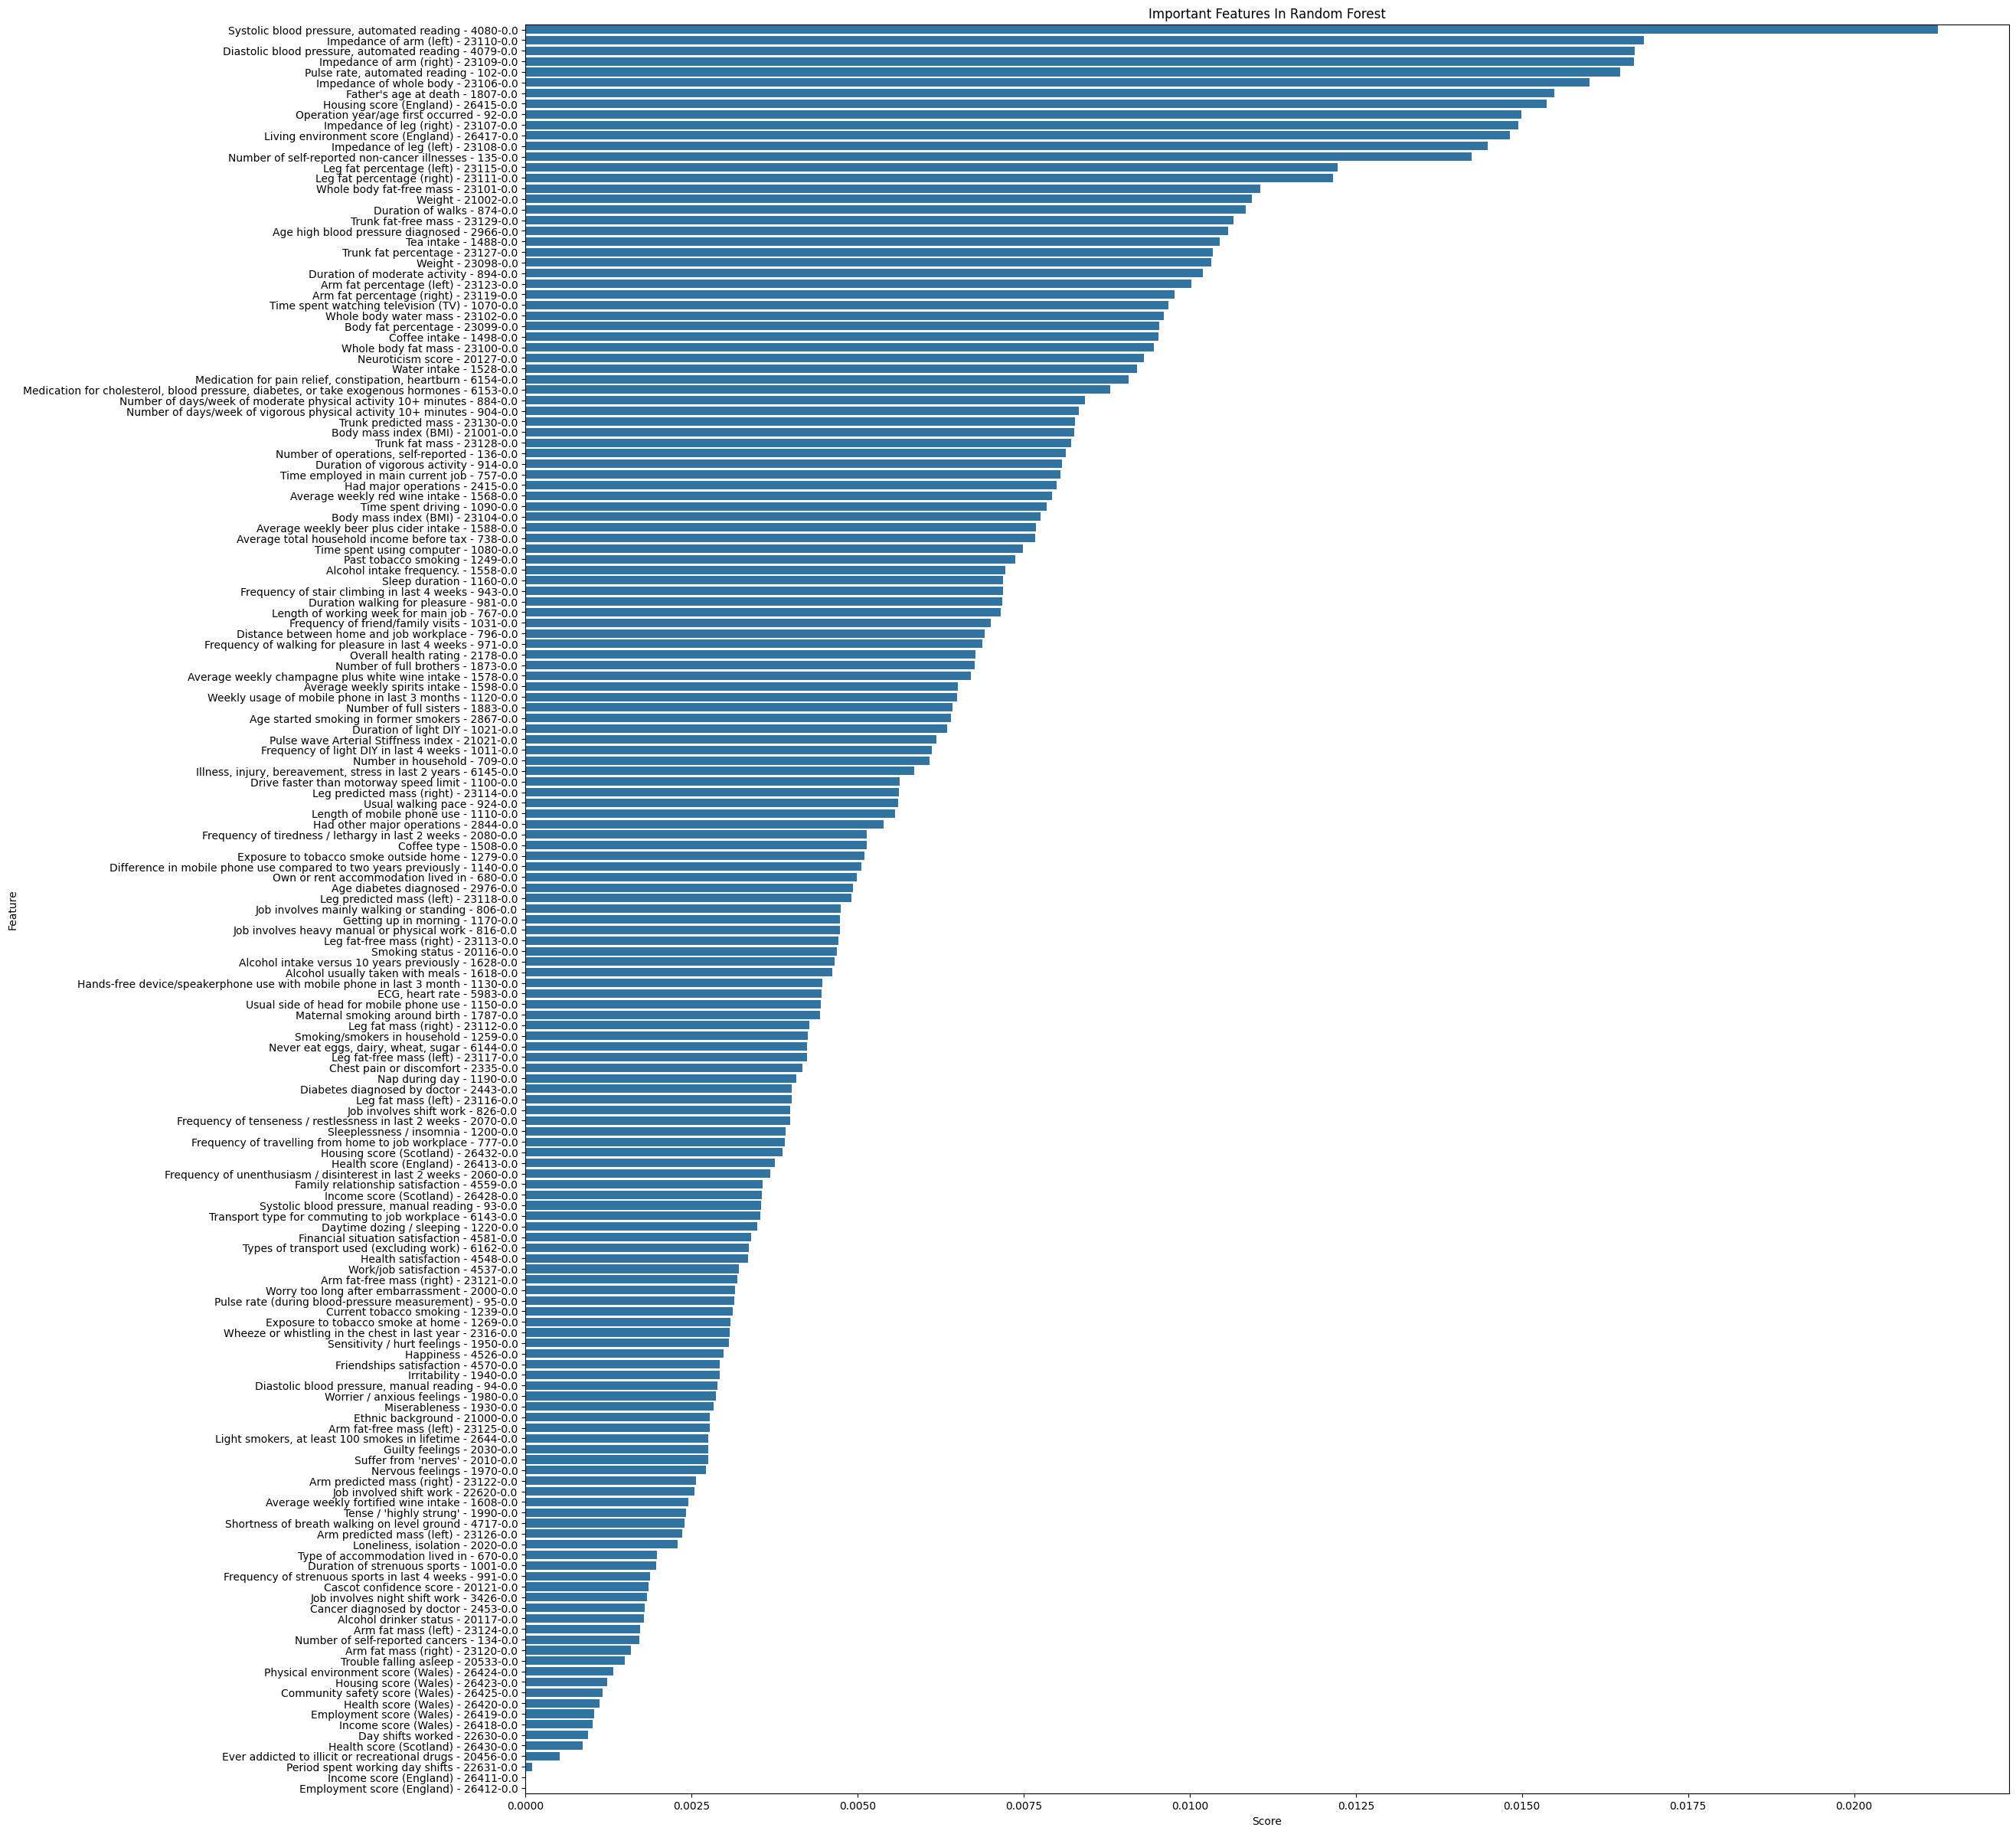

In [29]:
plt.figure(figsize=(25,30))
sns.barplot(x='Score',y='Real Feature Name' ,
            data=feature_importance_df,
            legend=True,
            dodge=False,
            )
plt.xlabel('Score')
plt.ylabel('Feature')
plt.title(f'Important Features In Random Forest')
plt.gca().invert_yaxis()
plt.show()

Accuracy Score: 0.798705966930266


Classification Report: 
               precision    recall  f1-score   support

       No MI       0.80      0.99      0.89      5564
          MI       0.45      0.03      0.06      1391

    accuracy                           0.80      6955
   macro avg       0.63      0.51      0.47      6955
weighted avg       0.73      0.80      0.72      6955



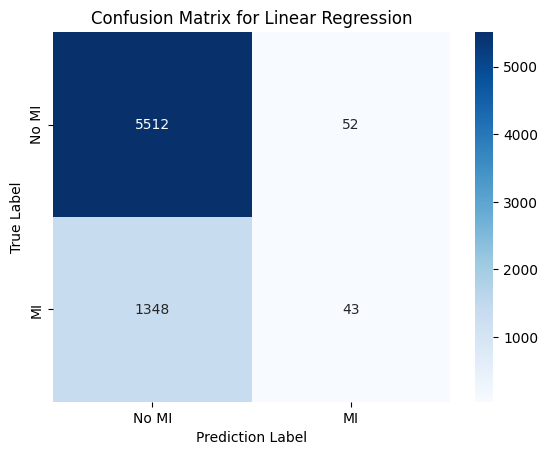

In [30]:
y_prediction = model.predict(X_val_final)

# accuracy_score
accuracy = accuracy_score(y_true=y_val,y_pred=y_prediction)

# confusion_matrix
cm = confusion_matrix(y_true=y_val,y_pred=y_prediction)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No MI', 'MI'], yticklabels=['No MI', 'MI'])
plt.xlabel('Prediction Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for RandomForestClassifier')

# Classification Report
report = classification_report(y_true=y_val, y_pred=y_prediction, target_names=['No MI', 'MI'] )

# Show results
print(f"Accuracy Score: {accuracy}")
print("\n\nClassification Report: \n", report)
plt.show()

***OverSampling***

In [33]:
from imblearn.over_sampling import RandomOverSampler

In [34]:
ros = RandomOverSampler(random_state=42)

In [46]:
X_resampled, y_resampled = ros.fit_resample(X_train_final, y_train)

In [38]:
model_on_overSample = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    bootstrap=True,
    random_state=42
)
model_on_overSample.fit(X_resampled, y_resampled)

RandomForestClassifier(random_state=42)

In [54]:
feature_importance_OS = model_on_overSample.feature_importances_
feature_importance_OS_df = pd.DataFrame({
    'Feature': X_resampled.columns,
    'Score': feature_importance_OS
    #,'selected': np.where(rfe.get_support(), 'Selected', 'Not Selected')
})

feature_importance_OS_df['Real Feature Name'] = feature_importance_OS_df['Feature'].apply(convert_feature_code_to_name)
feature_importance_OS_df = feature_importance_OS_df.sort_values(by='Score', ascending=True)

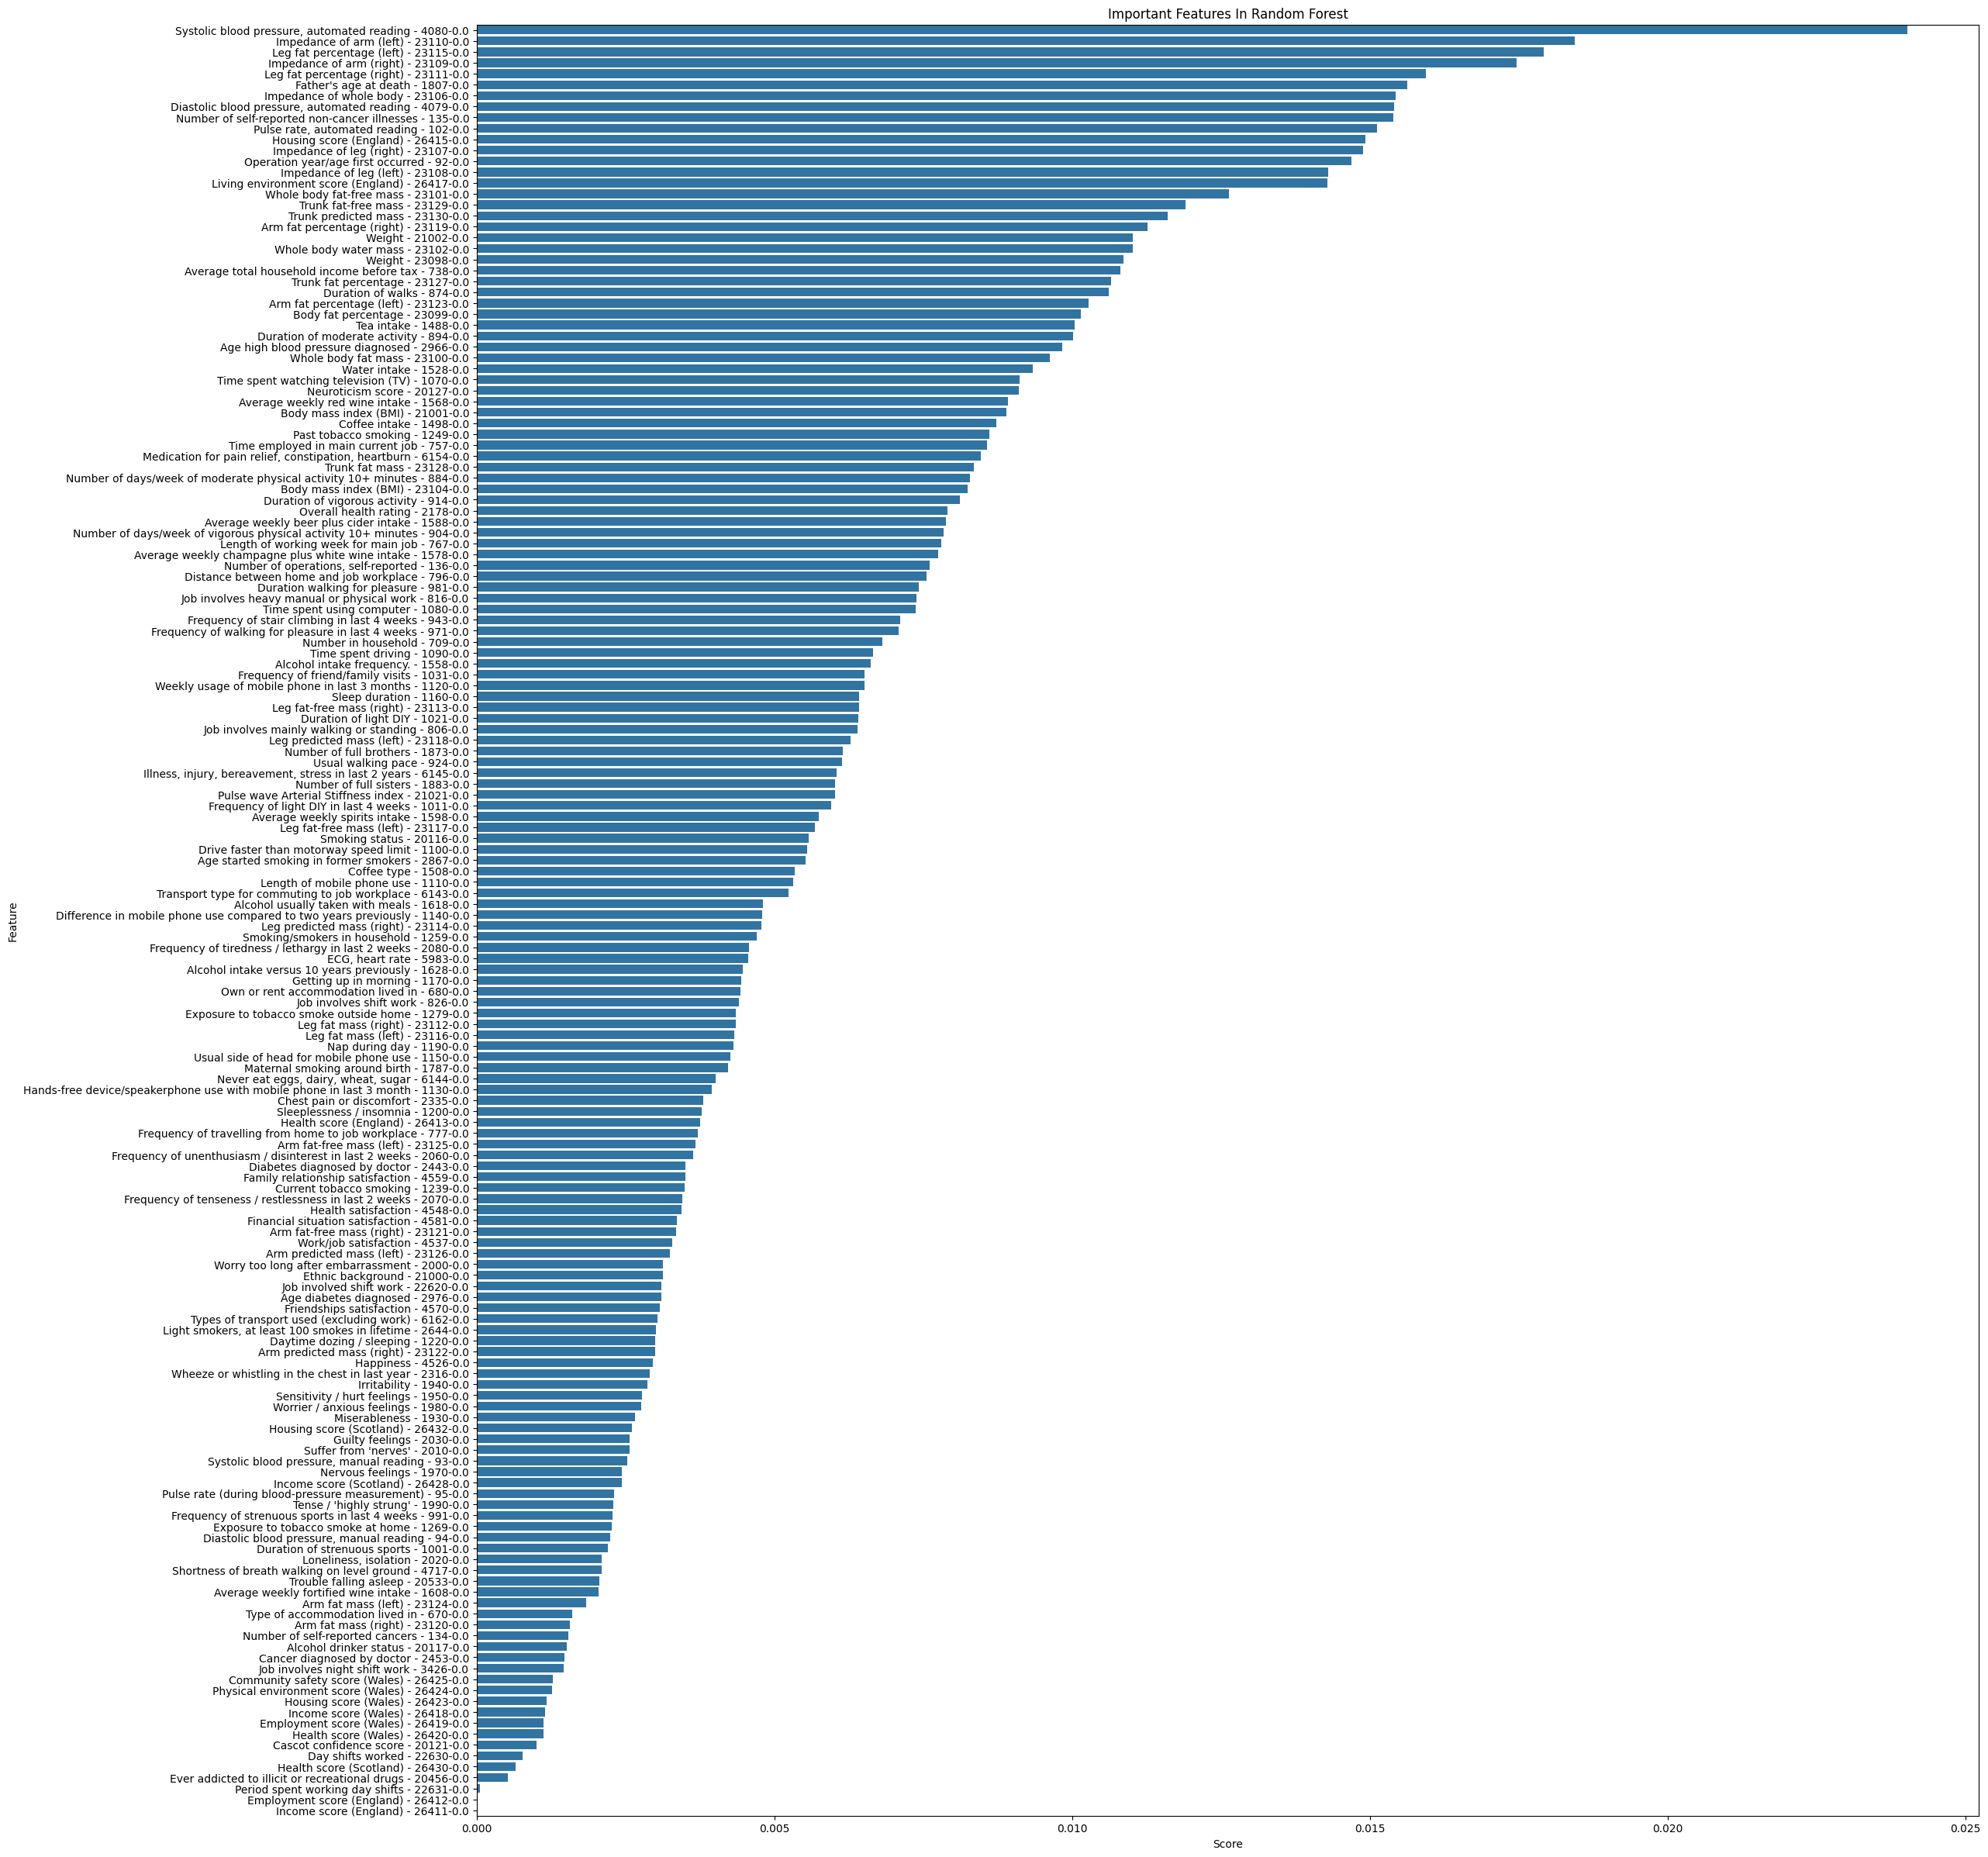

In [55]:
plt.figure(figsize=(25,30))
sns.barplot(x='Score',y='Real Feature Name' ,
            data=feature_importance_OS_df,
            legend=True,
            dodge=False,
            )
plt.xlabel('Score')
plt.ylabel('Feature')
plt.title(f'Important Features In Random Forest')
plt.gca().invert_yaxis()
plt.show()

Accuracy Score: 0.792235801581596


Classification Report: 
               precision    recall  f1-score   support

       No MI       0.81      0.97      0.88      5564
          MI       0.42      0.10      0.16      1391

    accuracy                           0.79      6955
   macro avg       0.61      0.53      0.52      6955
weighted avg       0.73      0.79      0.74      6955



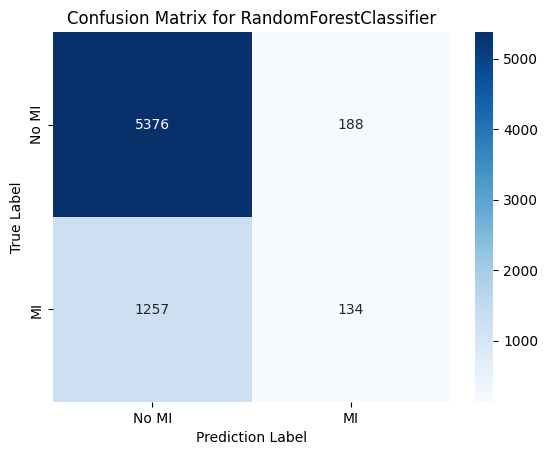

In [58]:
y_prediction = model_on_overSample.predict(X_val_final)

# accuracy_score
accuracy = accuracy_score(y_true=y_val,y_pred=y_prediction)

# confusion_matrix
cm = confusion_matrix(y_true=y_val,y_pred=y_prediction)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No MI', 'MI'], yticklabels=['No MI', 'MI'])
plt.xlabel('Prediction Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for RandomForestClassifier')

# Classification Report
report = classification_report(y_true=y_val, y_pred=y_prediction, target_names=['No MI', 'MI'] )

# Show results
print(f"Accuracy Score: {accuracy}")
print("\n\nClassification Report: \n", report)
plt.show()